In [1]:
import yaml
import os
from data import *
from models import *
from visualize import *
from utils import *
from sklearn.preprocessing import MinMaxScaler


In [2]:
with open(os.path.join('config.yaml')) as stream:
    config = yaml.safe_load(stream)


In [3]:
if config["dataset"]["download_required"]:
    download_and_save_data(config)

In [25]:
data = config["dataset"]["data"]
days = config["dataset"]["days"]
data_path = config["dataset"]["data_path"]
val_size = config["train_val"]["val_size"]
n_days_in = config["train_val"]["n_days_in"]
n_days_out = config["train_val"]["n_days_out"]
hidden_units = config["train_val"]["hidden_units"]
dropout = config["train_val"]["dropout"]
batch_size = config["train_val"]["batch_size"]
epochs = config["train_val"]["epochs"]
model_path = config["train_val"]["model_path"]
model_name = config["train_val"]["model_name"]
output_path = config["train_val"]["output_path"]

In [26]:
dates, price = load_data(data_path, data)

In [27]:
scaler = MinMaxScaler()

(800, 1)
(800, 1)
(200, 1)
(200, 1)


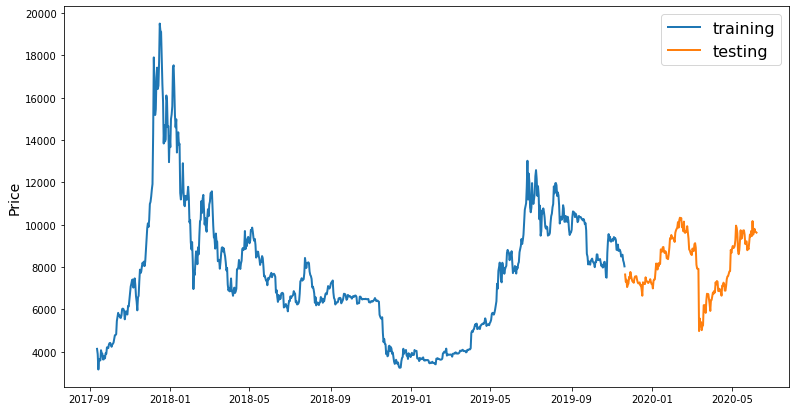

<Figure size 936x504 with 0 Axes>

In [28]:
train_dates, train_price, test_dates, test_price = split_data(dates, price, val_size)
line_plot(convert(train_dates), train_price, convert(test_dates), test_price, output_path[:-1]+'/train_val.png',
          'training', 'testing')


In [29]:
scaler = MinMaxScaler()
scaler.fit(train_price)
train_price = scaler.transform(train_price)
test_price = scaler.transform(test_price)


In [30]:
X_train_price, y_train_price = transform_data(train_price, n_days_in, n_days_out)
X_test_price, y_test_price = transform_data(test_price, n_days_in, n_days_out)


(770, 30, 1)
(770, 1)
(170, 30, 1)
(170, 1)


In [31]:
model = lstm(hidden_units, n_days_in, 1, n_days_out)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1)                 0         
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
model.compile(loss='mse', optimizer='adam')

In [45]:
model.fit(X_train_price, y_train_price, validation_data=(X_test_price, y_test_price), batch_size=batch_size, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 38ms/step - loss: 0.0013 - val_loss: 69994608.0000
Epoch 2/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 69994704.0000
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 69994976.0000
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 69994720.0000
Epoch 5/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 69994720.0000
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 69994800.0000
Epoch 7/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 69994480.0000
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 69994656.0000
Epoch 9/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 69994664.0000
Epoch 10/100
25/25 [=================

KeyboardInterrupt: 

In [35]:
path = model_path + model_name + '.h5'
model.save(path)

In [36]:
y_pred_price = model.predict(X_test_price)

In [37]:
y_pred_price[:2]

array([[0.2527039 ],
       [0.25419185]], dtype=float32)

In [38]:
y_test_price[:2]

array([[0.24697696],
       [0.26658419]])

In [39]:
y_pred_price = scaler.inverse_transform(y_pred_price)
y_test_price = scaler.inverse_transform(y_test_price)

In [40]:
y_pred_price[:2]

array([[7284.751 ],
       [7309.0674]], dtype=float32)

In [41]:
y_test_price[:2]

array([[7191.15869141],
       [7511.58886719]])

In [42]:
X_test_dates, y_test_dates = transform_data(test_dates, n_days_in, n_days_out)

(170, 30, 1)
(170, 1)


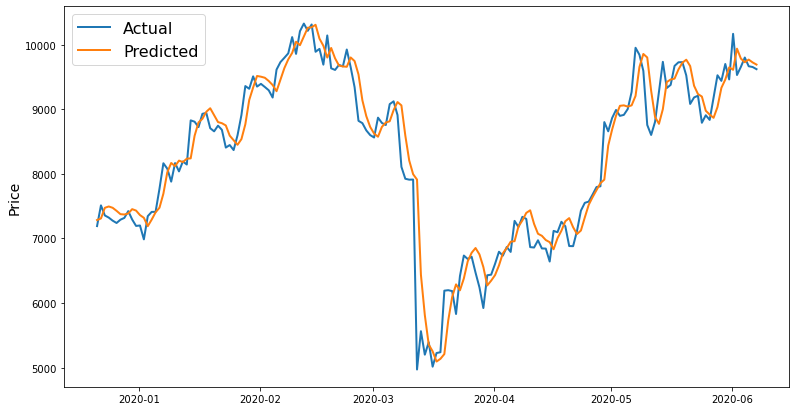

<Figure size 936x504 with 0 Axes>

In [43]:
line_plot(convert(y_test_dates), y_test_price, convert(y_test_dates), y_pred_price, output_path[:-1]+'/lstm.png',
          'Actual', 'Predicted')